In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls '/content/gdrive/My Drive/image classification project'

 data  'Image Classifier.ipynb'


In [4]:
dir = '/content/gdrive/My Drive/image classification project/data'

# Import Dependencies

In [5]:
import tensorflow as tf
import cv2 as cv
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import os

In [6]:
os .listdir(dir)

['happy', 'sad']

In [7]:
imgage_exts = ['jpeg','jpg','bmp','png']

In [8]:
imgage_exts[2]

'bmp'

In [9]:
for image_class in os.listdir(dir):
  for image in os.listdir(os.path.join(dir,image_class)):
    image_path = os.path.join(dir,image_class,image)
    try:
      img = cv.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in imgage_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))
      # os.remove(image_path)



# Load Data

In [10]:
tf.data.Dataset??

In [11]:
data = tf.keras.utils.image_dataset_from_directory(dir)

Found 763 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
batch[0].shape

(32, 256, 256, 3)

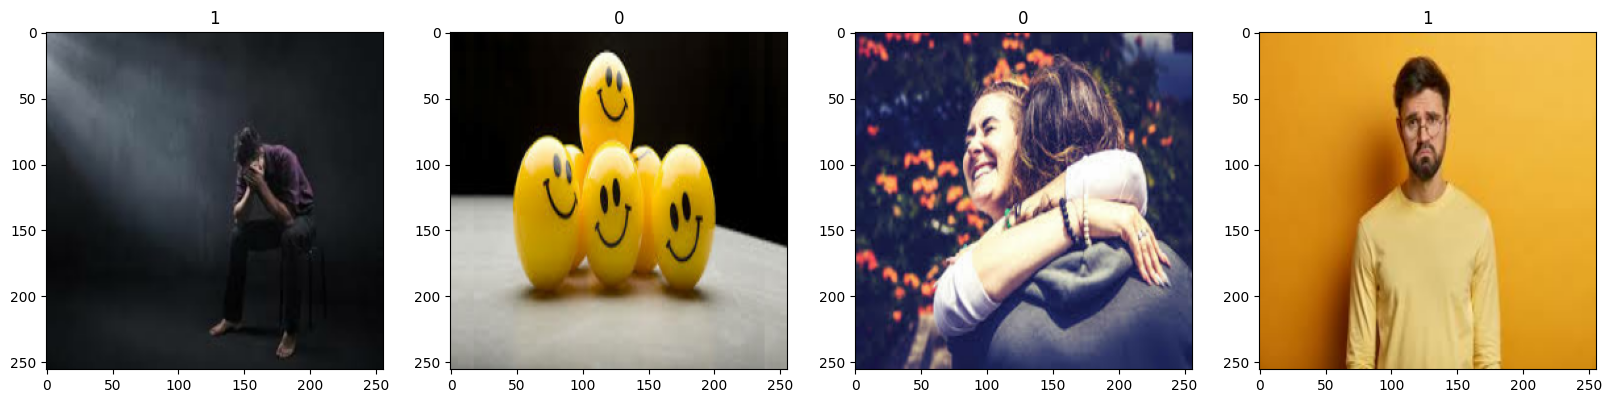

In [15]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# Preprocess Data

### 2.1 Scale Data


In [16]:
data = data.map(lambda x,y: (x/255,y))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

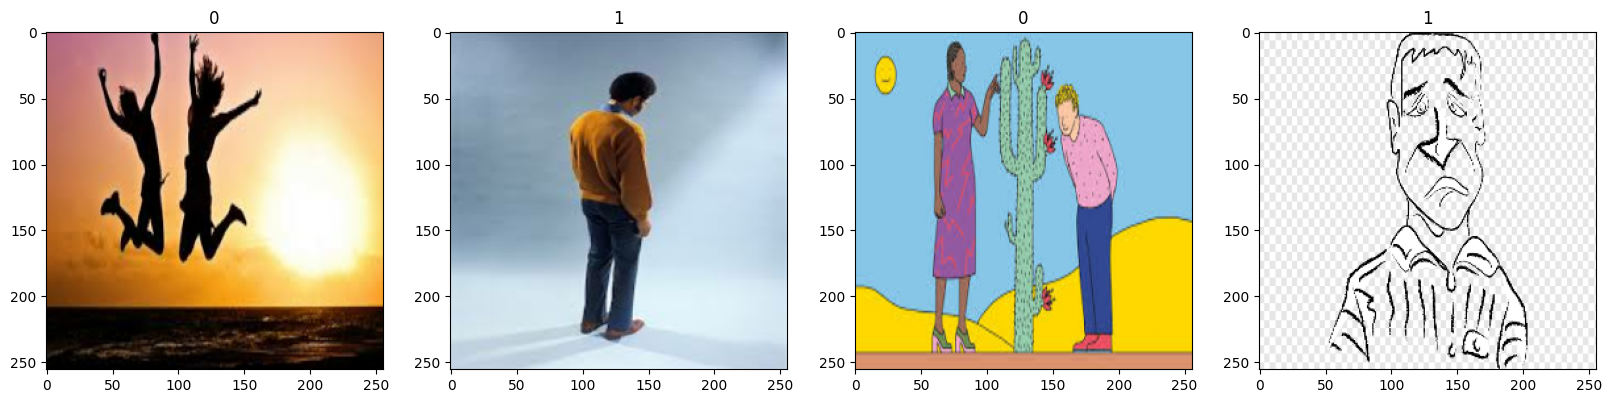

In [19]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

## Splitting the Data

In [20]:
len(data)

24

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [22]:
train_size + val_size + test_size

24

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Deep Model

#### 3.1 Build Deep learning Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

#### 3.2 Train

In [29]:
logdir = 'logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - accuracy: 0.5264 - loss: 0.7810 - val_accuracy: 0.6938 - val_loss: 0.6206
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 479ms/step - accuracy: 0.7120 - loss: 0.5881 - val_accuracy: 0.7000 - val_loss: 0.6256
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.7687 - loss: 0.5053 - val_accuracy: 0.8188 - val_loss: 0.4892
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 506ms/step - accuracy: 0.8345 - loss: 0.3960 - val_accuracy: 0.8375 - val_loss: 0.3772
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 690ms/step - accuracy: 0.8823 - loss: 0.2799 - val_accuracy: 0.8750 - val_loss: 0.2690
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 529ms/step - accuracy: 0.9435 - loss: 0.1795 - val_accuracy: 0.8813 - val_loss: 0.3029
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.9528 - loss: 0.1739 - val_accuracy: 0.9187 - val_loss: 0.2609
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.9606 - loss: 0.1092 - val_accuracy

In [32]:
hist.history

{'accuracy': [0.55859375,
  0.70703125,
  0.765625,
  0.83984375,
  0.888671875,
  0.935546875,
  0.939453125,
  0.9453125,
  0.962890625,
  0.970703125,
  0.984375,
  0.986328125,
  0.990234375,
  0.99609375,
  0.990234375,
  0.99609375,
  1.0,
  0.998046875,
  0.998046875,
  0.994140625],
 'loss': [0.7269294261932373,
  0.5760910511016846,
  0.496631383895874,
  0.3758354187011719,
  0.279316782951355,
  0.20451202988624573,
  0.18500009179115295,
  0.12699957191944122,
  0.11377720534801483,
  0.1358392834663391,
  0.07755595445632935,
  0.053161781281232834,
  0.05471938103437424,
  0.04546365886926651,
  0.021925117820501328,
  0.027061406522989273,
  0.012806292623281479,
  0.01033764611929655,
  0.03202556446194649,
  0.023256264626979828],
 'val_accuracy': [0.6937500238418579,
  0.699999988079071,
  0.8187500238418579,
  0.8374999761581421,
  0.875,
  0.8812500238418579,
  0.918749988079071,
  0.90625,
  0.96875,
  0.9624999761581421,
  0.949999988079071,
  0.956250011920929,
 

#### Plot Performance

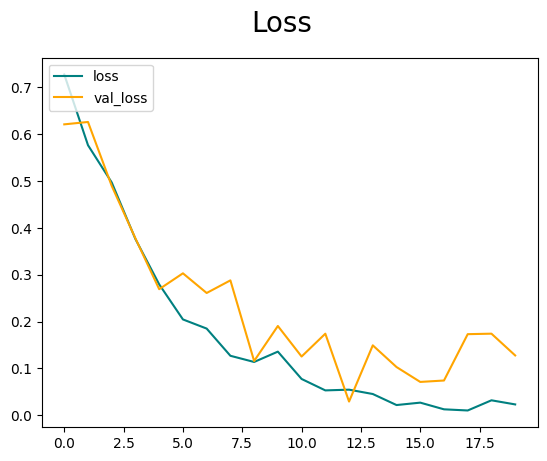

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

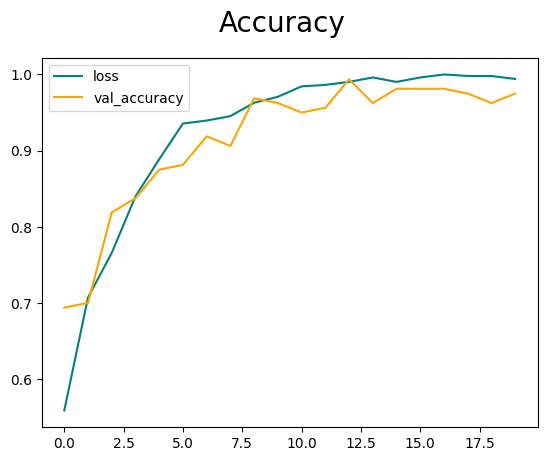

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='loss')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

### 4 Evaluate Performance

##### 4.1 Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


In [41]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


#### Test

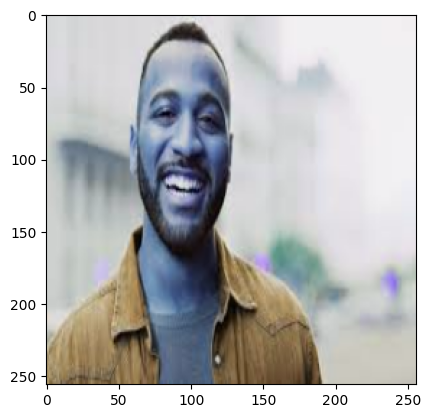

In [59]:
img = cv2.imread('/content/gdrive/My Drive/image classification project/data/happy.jpg')
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [60]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


In [61]:
yhat

array([[0.00020523]], dtype=float32)

In [64]:
if yhat > 0.5:
  print(f'Predicted class is Sad')
else:
  print(f'Predicted class is Happy')

Predicted class is Happy


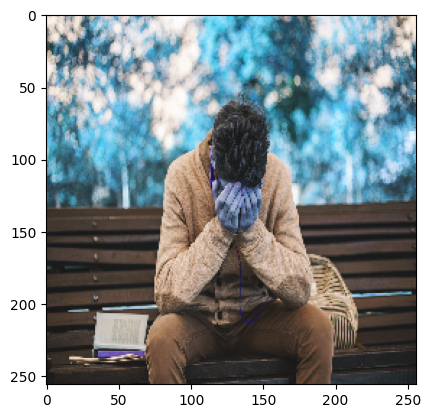

In [65]:
img = cv2.imread('/content/gdrive/My Drive/image classification project/data/sad.jpg')
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [66]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [67]:
if yhat > 0.5:
  print(f'Predicted class is Sad')
else:
  print(f'Predicted class is Happy')

Predicted class is Sad
